# **Airline Delay Dataset**

The below analyzes the delay data for airlines as is supplied by the Bureau of Transportation Statistics (BoTS). The below links can direct you to the data:
- [Overview of Delay Data](https://www.transtats.bts.gov/TableInfo.asp?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr&V0s1_b0yB=D)
- [Download Link for Delay Data](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr)
- [Data Dictionary](https://www.bts.gov/topics/airlines-and-airports/number-14-time-reporting)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from tabulate import tabulate
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

DATA_PATH = Path() / "data"

## Import data, format

In [4]:
selected_cols = [
    # flight identifiers / general data
    "FlightDate", "Tail_Number", 
    # "Flight_Number_Reporting_Airline",
    # "Flights", 
    "Distance", # "DistanceGroup",
    "FirstDepTime", # "TotalAddGTime", "LongestAddGTime",
    # departure, arrival time
    "CRSDepTime", # "DepTime", "DepTimeBlk",
    "CRSArrTime", # "ArrTime", "ArrTimeBlk",
    "ActualElapsedTime", # "AirTime", "CRSElapsedTime",
    # airline identifiers
    "Reporting_Airline", # "DOT_ID_Reporting_Airline", "IATA_CODE_Reporting_Airline",
    # origin
    "OriginAirportID", "OriginCityName", # "OriginAirportSeqID", "OriginCityMarketID", "Origin", "OriginCityName", "OriginState", "OriginStateFips", "OriginStateName", "OriginWac",
    # destination
    "DestAirportID", "DestCityName", # "DestAirportSeqID", "DestCityMarketID", "Dest", "DestCityName", "DestState", "DestStateFips", "DestStateName", "DestWac",
    # delay data
    "DepDelay","DepDelayMinutes","DepDel15","DepartureDelayGroups",
    "ArrDelay","ArrDelayMinutes","ArrDel15", "ArrivalDelayGroups",
    "CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay",
    # time spent data
    # "TaxiOut", "WheelsOff", "WheelsOn", "TaxiIn",
    # cancellation data
    "Cancelled", "CancellationCode", 
    # # diversion data
    # "Diverted", "DivAirportLandings", "DivReachedDest", "DivActualElapsedTime", "DivArrDelay", "DivDistance",
    # "Div1Airport","Div1AirportID","Div1AirportSeqID","Div1WheelsOn","Div1TotalGTime","Div1LongestGTime","Div1WheelsOff",
    # "Div1TailNum","Div2Airport","Div2AirportID","Div2AirportSeqID","Div2WheelsOn","Div2TotalGTime","Div2LongestGTime","Div2WheelsOff",
    # "Div2TailNum","Div3Airport","Div3AirportID","Div3AirportSeqID","Div3WheelsOn","Div3TotalGTime","Div3LongestGTime","Div3WheelsOff",
    # "Div3TailNum","Div4Airport","Div4AirportID","Div4AirportSeqID","Div4WheelsOn","Div4TotalGTime","Div4LongestGTime","Div4WheelsOff",
    # "Div4TailNum","Div5Airport","Div5AirportID","Div5AirportSeqID","Div5WheelsOn","Div5TotalGTime","Div5LongestGTime","Div5WheelsOff","Div5TailNum",
]

In [6]:
# Define the regex pattern for the filenames
pattern = re.compile(r"^\d{6}_flights\.csv$")

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through all files in the directory
for file in DATA_PATH.glob("*.csv"):
    print(file)
    if pattern.match(file.name):
        # Read the CSV and append to the list
        df_month = pd.read_csv(file, low_memory=False)
        dataframes.append(df_month[selected_cols])

# Concatenate all DataFrames into one
if dataframes:
    df_raw = pd.concat(dataframes, ignore_index=True)
else:
    df_raw = pd.DataFrame()  # Empty DataFrame if no matching files found


data\202307_flights.csv
data\202308_flights.csv
data\202309_flights.csv
data\202310_flights.csv
data\202311_flights.csv
data\202312_flights.csv
data\202401_flights.csv
data\202402_flights.csv
data\202403_flights.csv
data\202404_flights.csv
data\202405_flights.csv
data\202406_flights.csv
data\airline_codes_map.csv
data\airport_id_map.csv


In [8]:
df = df_raw.copy()
df["FlightDate"] = pd.to_datetime(df["FlightDate"], format="%Y-%m-%d")
df.to_csv(DATA_PATH / f"aggregate_flights.csv", index=False)
df.head()

,FlightDate,Tail_Number,Distance,FirstDepTime,CRSDepTime,CRSArrTime,ActualElapsedTime,Reporting_Airline,OriginAirportID,OriginCityName,...,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode
0,2023-07-02,N307PQ,533.0,NaN,946,1034,93.0,9E,11433,"Detroit, MI",...,0.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,2023-07-05,N232PQ,533.0,NaN,1355,1442,95.0,9E,11433,"Detroit, MI",...,0.0,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,2023-07-09,N480PX,533.0,NaN,946,1034,96.0,9E,11433,"Detroit, MI",...,0.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,2023-07-10,N304PQ,970.0,NaN,619,820,156.0,9E,14524,"Richmond, VA",...,0.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,2023-07-11,N184GJ,970.0,NaN,619,820,161.0,9E,14524,"Richmond, VA",...,0.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6968649 entries, 0 to 6968648
Data columns (total 27 columns):
 #   Column                Dtype         
---  ------                -----         
 0   FlightDate            datetime64[ns]
 1   Tail_Number           object        
 2   Distance              float64       
 3   FirstDepTime          float64       
 4   CRSDepTime            int64         
 5   CRSArrTime            int64         
 6   ActualElapsedTime     float64       
 7   Reporting_Airline     object        
 8   OriginAirportID       int64         
 9   OriginCityName        object        
 10  DestAirportID         int64         
 11  DestCityName          object        
 12  DepDelay              float64       
 13  DepDelayMinutes       float64       
 14  DepDel15              float64       
 15  DepartureDelayGroups  float64       
 16  ArrDelay              float64       
 17  ArrDelayMinutes       float64       
 18  ArrDel15              float64       
 19  

In [10]:
df['CRSDepTime'] = df['CRSDepTime'].apply(lambda x: int(str(x).zfill(4)) if pd.notnull(x) else None).astype('Int64')
df['CRSArrTime'] = df['CRSArrTime'].apply(lambda x: int(str(x).zfill(4)) if pd.notnull(x) else None).astype('Int64')

### **Mapping Coded Columns**

In [11]:
cancellation_code_map = dict(
    A="Carrier Caused",
    B="Weather",
    C="National Aviation System",
    D="Security",
)
df.CancellationCode = df.CancellationCode.map(cancellation_code_map)

In [12]:
# https://www.bts.gov/topics/airlines-and-airports/airline-codes
airline_codes_map = pd.read_csv(DATA_PATH / "airline_codes_map.csv")
df = df.join(airline_codes_map.set_index("Reporting_Airline"), on="Reporting_Airline")

In [13]:
# https://www.transtats.bts.gov/FieldInfo.asp?Svryq_Qr5p=b4vtv0%FDNv42146%FP%FDNv42146%FDVQ.%FDN0%FDvqr06vsvpn6v10%FD07zor4%FDn55vt0rq%FDoB%FDhf%FDQbg%FD61%FDvqr06vsB%FDn%FD70v37r%FDnv42146.%FD%FDh5r%FD6uv5%FDsvryq%FDs14%FDnv42146%FDn0nyB5v5%FDnp4155%FDn%FD4n0tr%FD1s%FDBrn45%FDorpn75r%FDn0%FDnv42146%FDpn0%FDpun0tr%FDv65%FDnv42146%FDp1qr%FDn0q%FDnv42146%FDp1qr5%FDpn0%FDor%FD4r75rq.&Svryq_gB2r=a7z&Y11x72_gnoyr=Y_NVecbeg_VQ&gnoyr_VQ=FMF&flf_gnoyr_anzr=g_gEDD_ZNeXRg_NYY_PNeeVRe&fB5_Svryq_anzr=beVTVa_NVecbeg_VQ
aiport_id_map = pd.read_csv(DATA_PATH / "airport_id_map.csv")
aiport_id_map = pd.Series(aiport_id_map.Airport_Name.values, index=aiport_id_map.Code).to_dict()
df["OriginAirportName"] = df["OriginAirportID"].map(aiport_id_map)
df["DestAirportName"] = df["DestAirportID"].map(aiport_id_map)

In [14]:
def freeman_diaconis_bins(data):
    quartiles = np.percentile(data, [25, 75])
    iqr = quartiles[1] - quartiles[0]  
    bin_width = 2 * iqr / len(data) ** (1/3)  
    bins = int((data.max() - data.min()) / bin_width) 
    return max(bins, 1)  

def hist(df, column_name, bins=None, color='grey', title=None):

    data = df[column_name].dropna()

    if bins is None:
        bins = freeman_diaconis_bins(data)

    n = len(data)
    weights = np.ones(n) / n  

    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.7, weights=weights)
    plt.title(title or f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Relative Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()


def describe_corr_strength(value):
    abs_value = abs(value)
    if abs_value < 0.16:
        return "very weak"
    elif abs_value < 0.29:
        return "weak"
    elif abs_value < 0.49:
        return "low"
    elif abs_value < 0.69:
        return "moderate"
    elif abs_value < 0.89:
        return "strong"
    else:
        return "very strong"

def compute_correlations(data, var1, var2):
    print("Correlation Summary:")
    pearson_corr, _ = pearsonr(data[var1], data[var2])
    spearman_corr, _ = spearmanr(data[var1], data[var2])
    print(f"Pearson r   = {pearson_corr:.2f} ({describe_corr_strength(pearson_corr)})")
    print(f"Spearman ρ = {spearman_corr:.2f} ({describe_corr_strength(spearman_corr)})")


def scatter_with_trend(data, x_var, y_var):
    plt.figure(figsize=(10, 6))
    sns.regplot(x=x_var, y=y_var, data=data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f"{y_var} vs {x_var}")
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.grid(True)
    plt.show()


def plot_grouped_distributions(data, category_col, numeric_col, rows=None, cols=4, figsize=(25, 35)):
    categories = data[category_col].unique()
    num_categories = len(categories)
    if rows is None:
        rows = (num_categories + cols - 1) // cols  
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()  

    for i, category in enumerate(categories):
        subset = data[data[category_col] == category]
        sns.histplot(subset[numeric_col], bins=20, kde=True, ax=axes[i], color="grey")
        axes[i].set_title(f"{category} - {numeric_col}")
        axes[i].set_xlabel(numeric_col)
        axes[i].set_ylabel("Density")

    for ax in axes[num_categories:]:
        ax.set_visible(False)

    plt.show()


In [15]:
missing_data = df.isnull().sum()
print(missing_data)


FlightDate                    0
Tail_Number               17032
Distance                      0
FirstDepTime            6919715
CRSDepTime                    0
CRSArrTime                    0
ActualElapsedTime        101740
Reporting_Airline             0
OriginAirportID               0
OriginCityName                0
DestAirportID                 0
DestCityName                  0
DepDelay                  81433
DepDelayMinutes           81433
DepDel15                  81433
DepartureDelayGroups      81433
ArrDelay                 101740
ArrDelayMinutes          101740
ArrDel15                 101740
ArrivalDelayGroups       101740
CarrierDelay            5561299
WeatherDelay            5561299
NASDelay                5561299
SecurityDelay           5561299
LateAircraftDelay       5561299
Cancelled                     0
CancellationCode        6883878
Airline_Name                  0
OriginAirportName             0
DestAirportName               0
dtype: int64


In [16]:
missing_percentage = (df.isnull().mean() * 100).sort_values(ascending=False)
print(missing_percentage)

FirstDepTime            99.297798
CancellationCode        98.783538
NASDelay                79.804550
CarrierDelay            79.804550
WeatherDelay            79.804550
LateAircraftDelay       79.804550
SecurityDelay           79.804550
ArrDel15                 1.459967
ArrDelayMinutes          1.459967
ArrDelay                 1.459967
ArrivalDelayGroups       1.459967
ActualElapsedTime        1.459967
DepDelay                 1.168562
DepDelayMinutes          1.168562
DepDel15                 1.168562
DepartureDelayGroups     1.168562
Tail_Number              0.244409
Cancelled                0.000000
Airline_Name             0.000000
OriginAirportName        0.000000
FlightDate               0.000000
DestCityName             0.000000
DestAirportID            0.000000
OriginCityName           0.000000
OriginAirportID          0.000000
Reporting_Airline        0.000000
CRSArrTime               0.000000
CRSDepTime               0.000000
Distance                 0.000000
DestAirportNam

In [17]:
delay_components = ['SecurityDelay', 'CarrierDelay', 'NASDelay', 'LateAircraftDelay', 'WeatherDelay']
for col in delay_components:
    df[f'{col}_missing'] = df[col].isnull().astype(int)

for col in delay_components:
    corr = df[f'{col}_missing'].corr(df['ArrDelay'])
    print(f'Correlation between missing {col} and ArrDelay: {corr}')

Correlation between missing SecurityDelay and ArrDelay: -0.560882433806795
Correlation between missing CarrierDelay and ArrDelay: -0.560882433806795
Correlation between missing NASDelay and ArrDelay: -0.560882433806795
Correlation between missing LateAircraftDelay and ArrDelay: -0.560882433806795
Correlation between missing WeatherDelay and ArrDelay: -0.560882433806795


In [18]:
df.drop(['FirstDepTime', 'CancellationCode','Tail_Number'], axis=1, inplace=True)

In [19]:
df[delay_components] = df[delay_components].fillna(0)

In [20]:
# #KNN Imputer
# columns_to_impute = [
#     'ActualElapsedTime', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 
#     'ArrDelay', 'DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups']

# df_to_impute = df[columns_to_impute]
# knn_imputer = KNNImputer(n_neighbors=5)
# df_imputed = knn_imputer.fit_transform(df_to_impute)
# df_imputed = pd.DataFrame(df_imputed, columns=columns_to_impute)
# df[columns_to_impute] = df_imputed
# print(df[columns_to_impute].isnull().sum())


In [21]:
columns_to_impute = [
    'ActualElapsedTime', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 
    'ArrDelay', 'DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups'
]
df[columns_to_impute] = df[columns_to_impute].fillna(df[columns_to_impute].mean())

In [22]:
missing_percentage = (df.isnull().mean() * 100).sort_values(ascending=False)
print(missing_percentage)

FlightDate                   0.0
Distance                     0.0
LateAircraftDelay_missing    0.0
NASDelay_missing             0.0
CarrierDelay_missing         0.0
SecurityDelay_missing        0.0
DestAirportName              0.0
OriginAirportName            0.0
Airline_Name                 0.0
Cancelled                    0.0
LateAircraftDelay            0.0
SecurityDelay                0.0
NASDelay                     0.0
WeatherDelay                 0.0
CarrierDelay                 0.0
ArrivalDelayGroups           0.0
ArrDel15                     0.0
ArrDelayMinutes              0.0
ArrDelay                     0.0
DepartureDelayGroups         0.0
DepDel15                     0.0
DepDelayMinutes              0.0
DepDelay                     0.0
DestCityName                 0.0
DestAirportID                0.0
OriginCityName               0.0
OriginAirportID              0.0
Reporting_Airline            0.0
ActualElapsedTime            0.0
CRSArrTime                   0.0
CRSDepTime

## **Exploratory Data Analysis**

## Single Variable EDA

We will begin our EDA with individual variables. This approach will allow us understand each variable's unique characteristics and its impact on the dataset before exploring pairwise relationships.

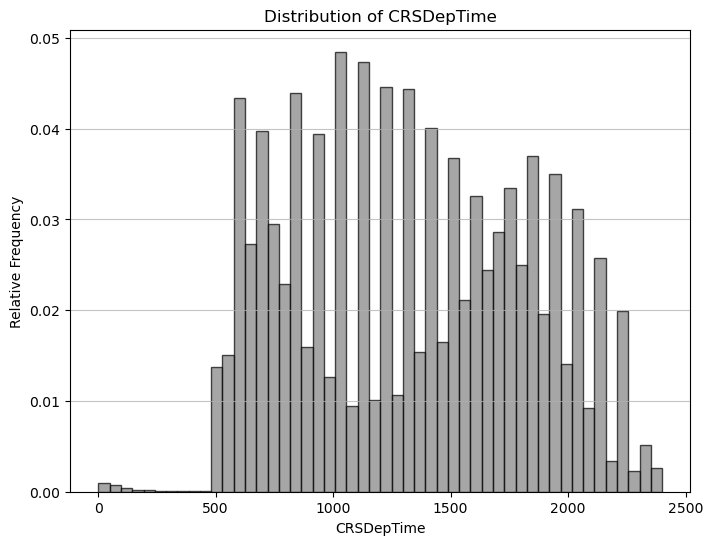

In [19]:
hist(df, 'CRSDepTime', bins=50)

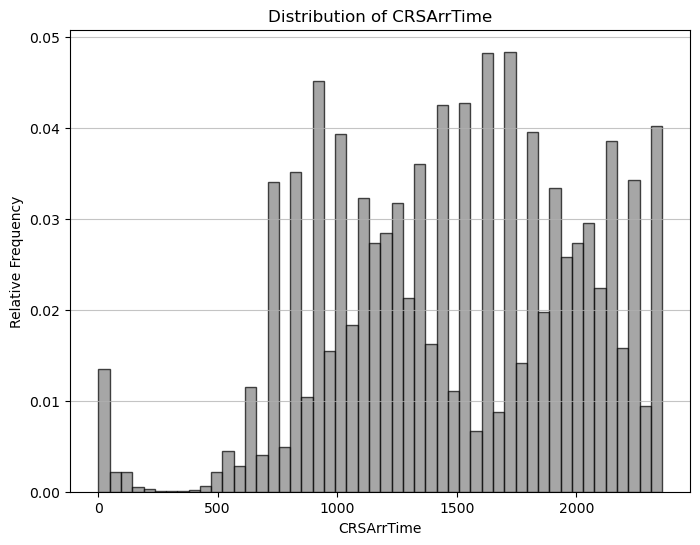

In [20]:
hist(df, 'CRSArrTime', bins=50)

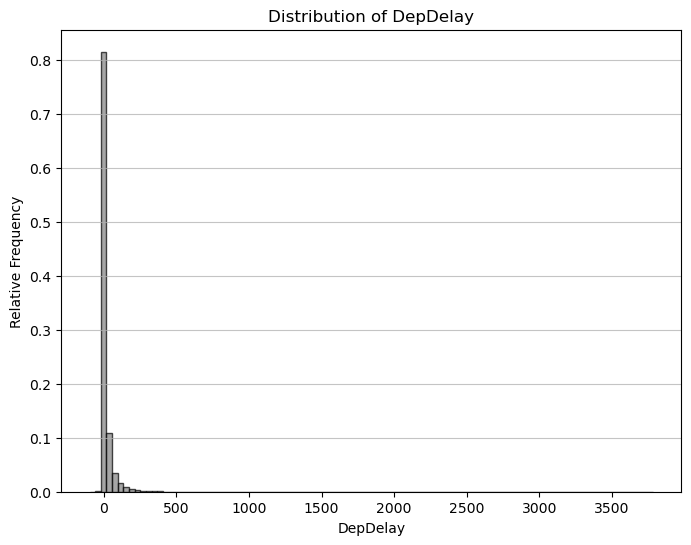

In [21]:
hist(df, 'DepDelay', bins=100)

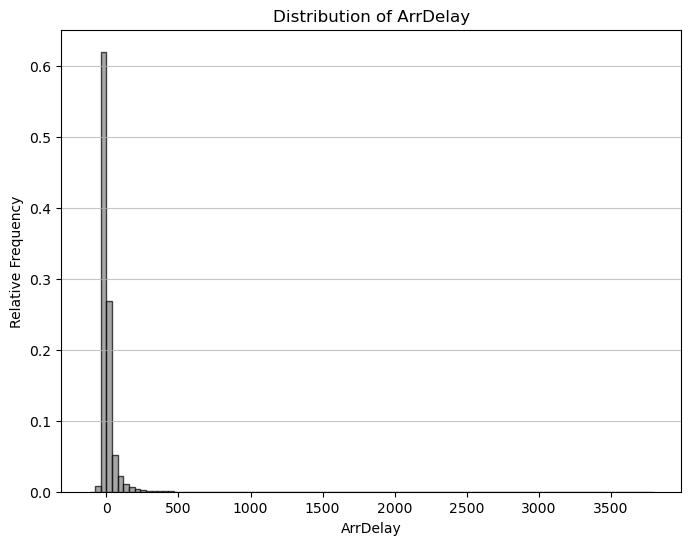

In [22]:
hist(df, 'ArrDelay', bins=100)

In [23]:
df.Distance.describe()

count    6.968649e+06
mean     8.365516e+02
std      5.970741e+02
min      2.100000e+01
25%      4.020000e+02
50%      6.850000e+02
75%      1.069000e+03
max      5.095000e+03
Name: Distance, dtype: float64

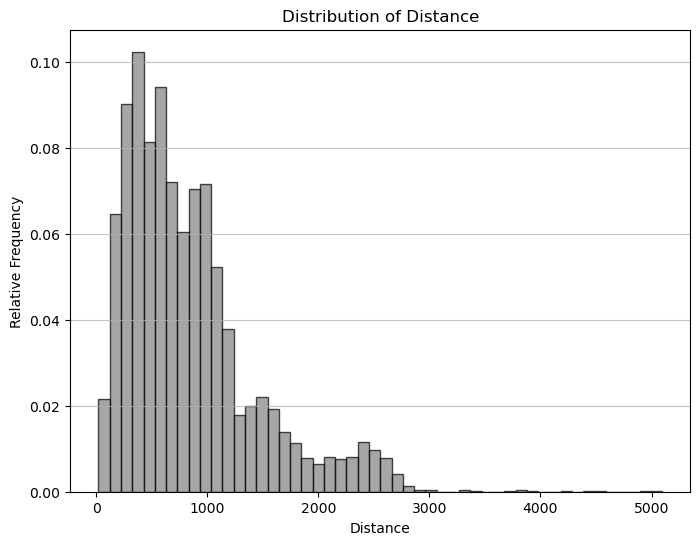

In [24]:
hist(df, 'Distance', bins=50)

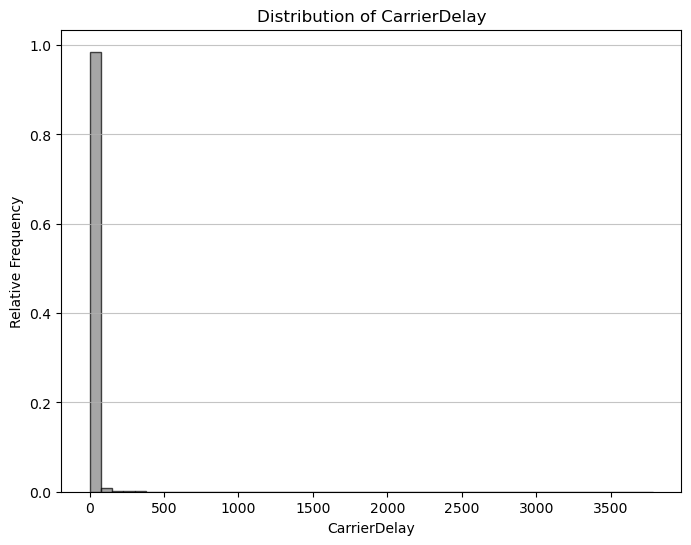

In [25]:
hist(df, 'CarrierDelay', bins=50)

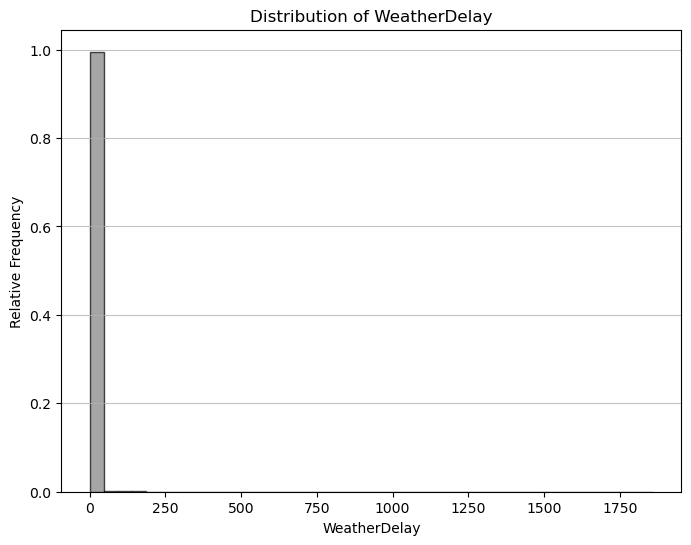

In [26]:
hist(df, 'WeatherDelay', bins=40)

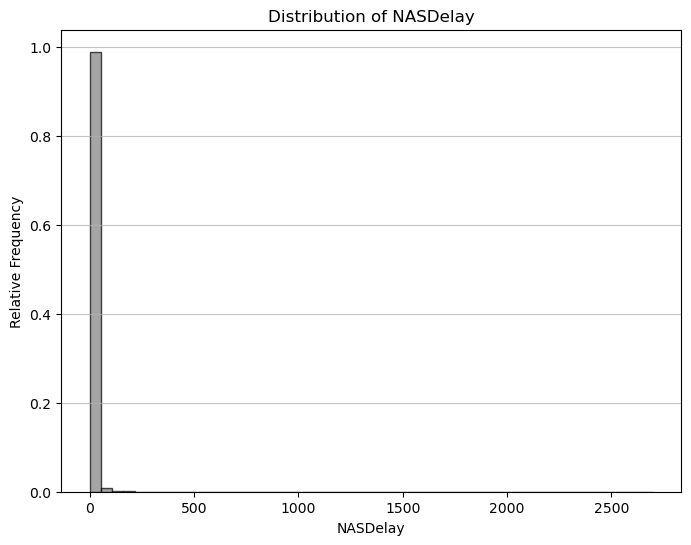

In [27]:
hist(df, 'NASDelay', bins=50)

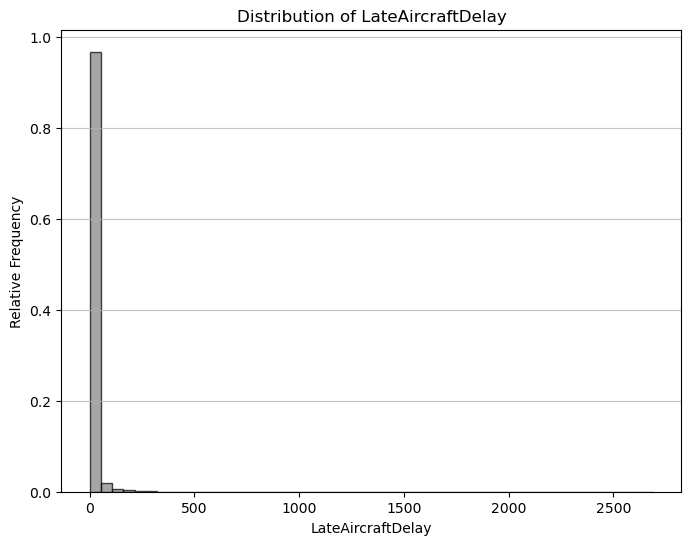

In [28]:
hist(df, 'LateAircraftDelay', bins=50)

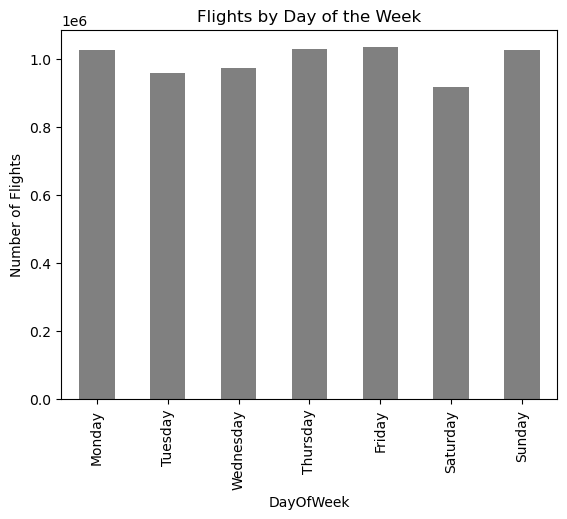

In [29]:
df['DayOfWeek'] = df['FlightDate'].dt.day_name()
flights_by_day = df.groupby('DayOfWeek').size().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
flights_by_day.plot(kind='bar', color='grey', title="Flights by Day of the Week")
plt.ylabel('Number of Flights')
plt.show()


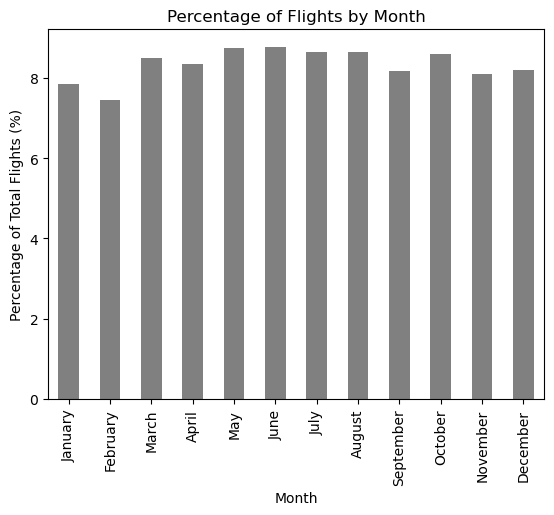

In [30]:
df['Month'] = df['FlightDate'].dt.month_name()

flights_by_month = df.groupby('Month').size().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

flights_by_month = (flights_by_month / flights_by_month.sum()) * 100
flights_by_month.plot(kind='bar', color='grey', title="Percentage of Flights by Month")
plt.ylabel('Percentage of Total Flights (%)')
plt.show()


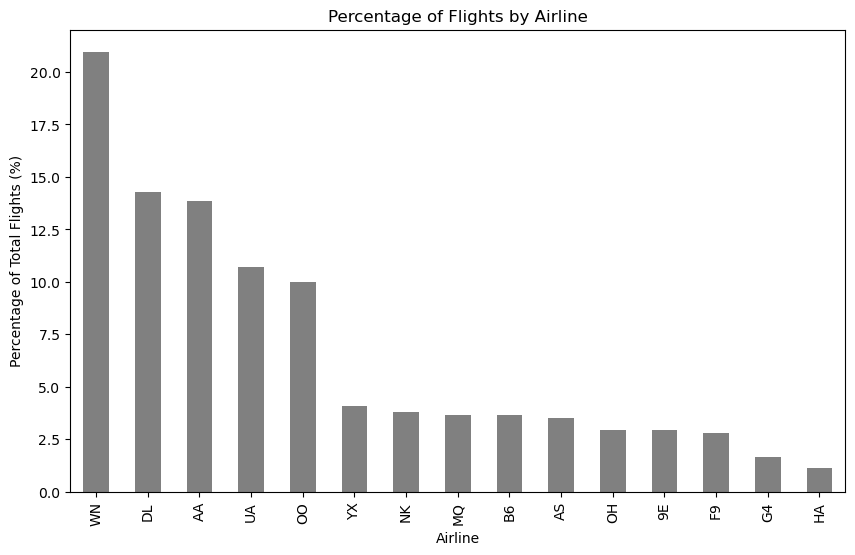

In [31]:
flights_by_airline = df['Reporting_Airline'].value_counts(normalize=True) * 100
flights_by_airline.plot(kind='bar', color='grey', figsize=(10, 6), title="Percentage of Flights by Airline")
plt.xlabel('Airline')
plt.ylabel('Percentage of Total Flights (%)')
plt.show()


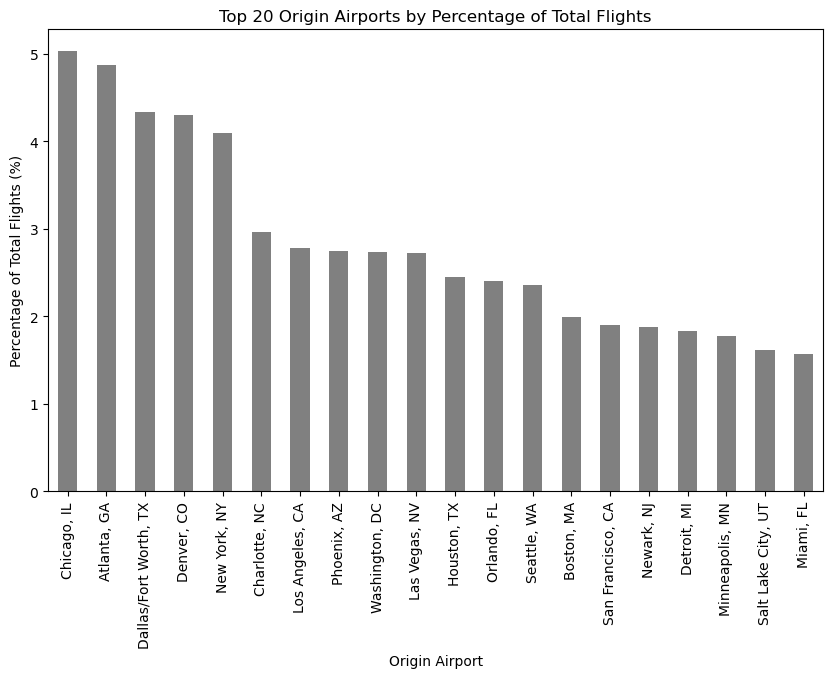

In [32]:
flights_by_airport = df['OriginCityName'].value_counts()
flights_by_airport = (flights_by_airport / flights_by_airport.sum()) * 100

flights_by_airport.head(20).plot(kind='bar', color='grey', figsize=(10, 6), 
                                 title="Top 20 Origin Airports by Percentage of Total Flights")
plt.xlabel('Origin Airport')
plt.ylabel('Percentage of Total Flights (%)')
plt.show()


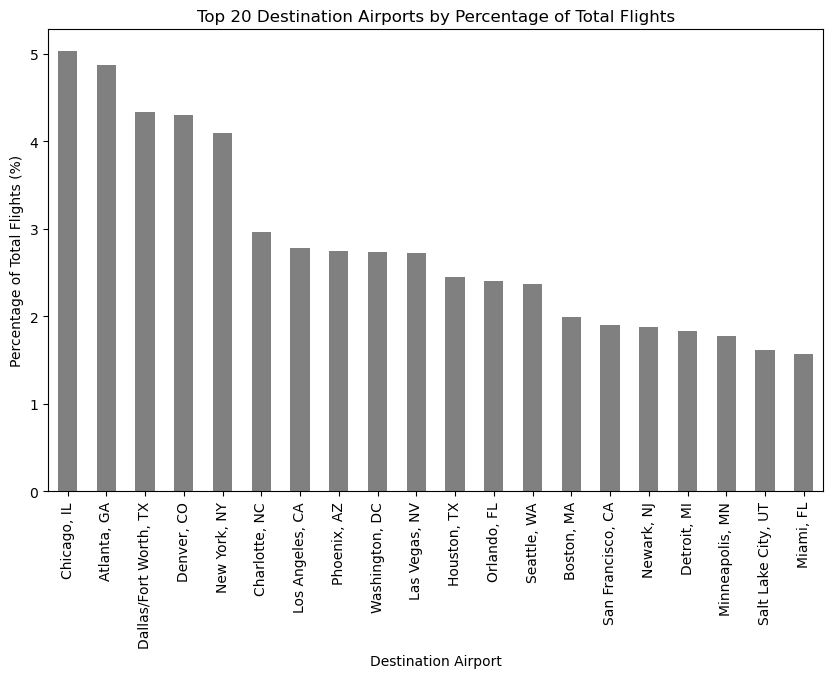

In [33]:
flights_by_airport = df['DestCityName'].value_counts()
flights_by_airport = (flights_by_airport / flights_by_airport.sum()) * 100
flights_by_airport.head(20).plot(kind='bar', color='grey', figsize=(10, 6), 
                                 title="Top 20 Destination Airports by Percentage of Total Flights")

plt.xlabel('Destination Airport')
plt.ylabel('Percentage of Total Flights (%)')
plt.show()


Many flights are round-trip or symmetrical routes, meaning flights that depart from a specific airport (e.g., Chicago O'Hare) also return to it or operate in both directions regularly. 

In [34]:
df.Cancelled.describe()

count    6.968649e+06
mean     1.216462e-02
std      1.096205e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: Cancelled, dtype: float64

## Pairwise EDA

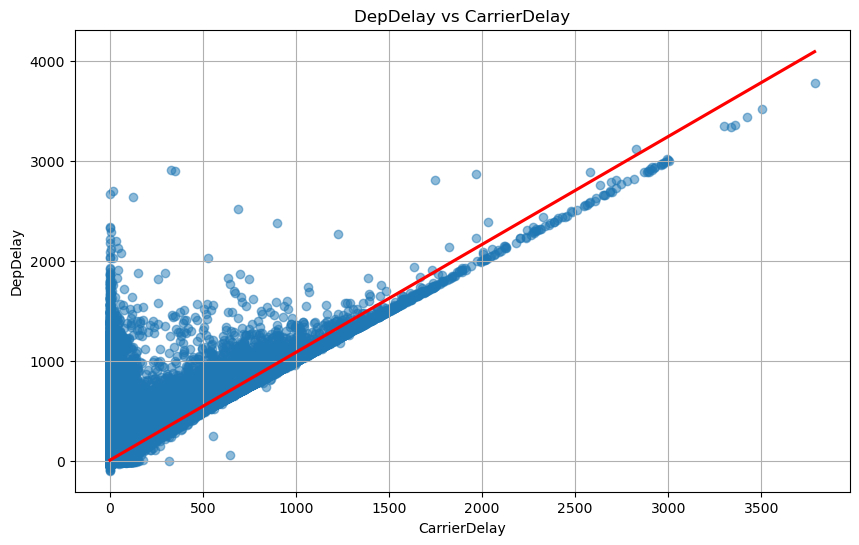

Correlation Summary:
Pearson r   = 0.70 (strong)
Spearman ρ = 0.47 (low)


In [35]:
scatter_with_trend(df, 'CarrierDelay', 'DepDelay')
compute_correlations(df, 'CarrierDelay', 'DepDelay')

In [ ]:
scatter_with_trend(df, 'WeatherDelay', 'ArrDelay')
compute_correlations(df, 'WeatherDelay', 'ArrDelay')

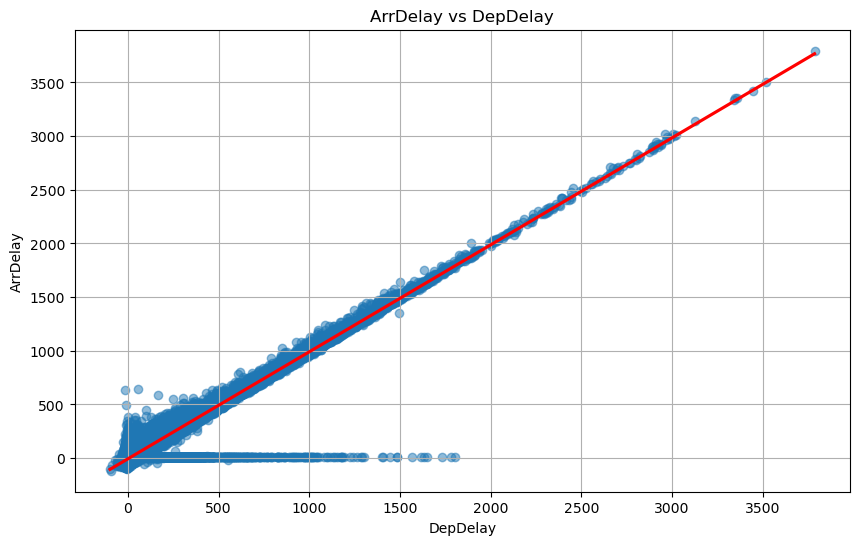

Correlation Summary:
Pearson r   = 0.97 (very strong)
Spearman ρ = 0.70 (strong)


In [37]:
scatter_with_trend(df, 'DepDelay', 'ArrDelay')
compute_correlations(df, 'DepDelay', 'ArrDelay')

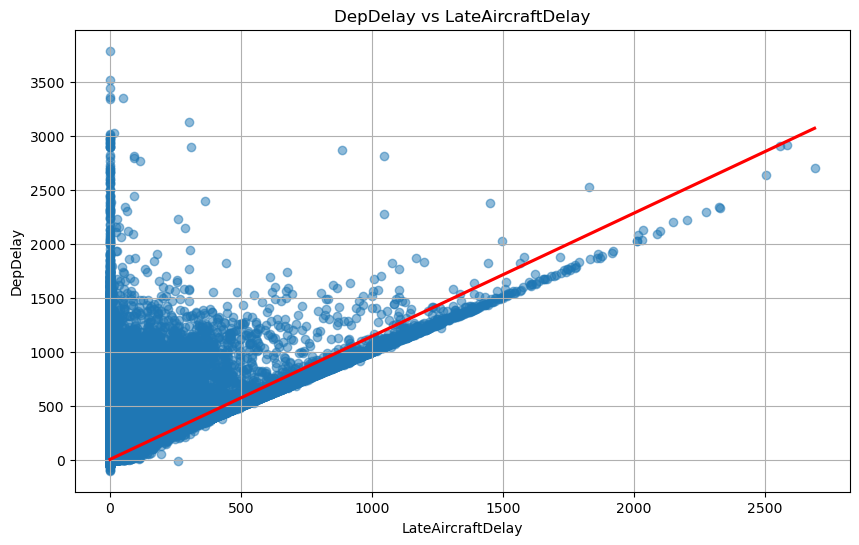

Correlation Summary:
Pearson r   = 0.63 (moderate)
Spearman ρ = 0.49 (low)


In [38]:
scatter_with_trend(df, 'LateAircraftDelay', 'DepDelay')
compute_correlations(df, 'LateAircraftDelay', 'DepDelay')

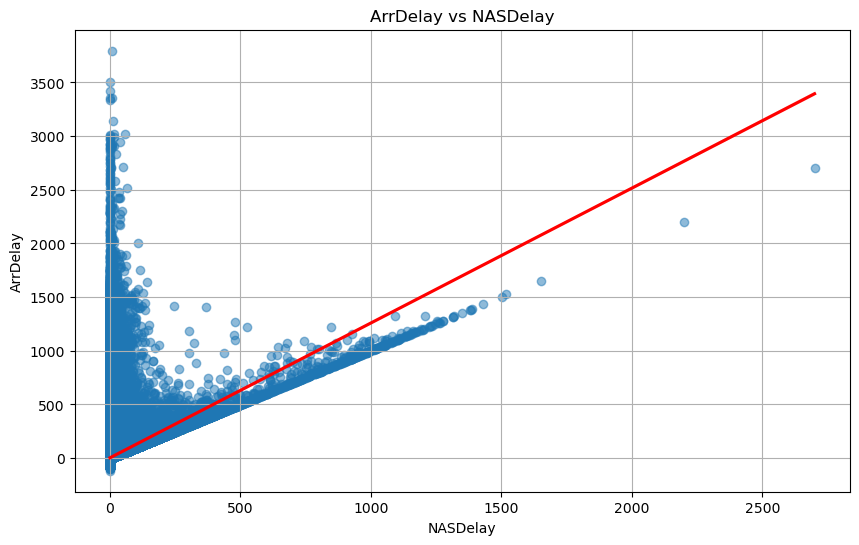

Correlation Summary:
Pearson r   = 0.33 (low)
Spearman ρ = 0.45 (low)


In [39]:
scatter_with_trend(df, 'NASDelay', 'ArrDelay')
compute_correlations(df, 'NASDelay', 'ArrDelay')

/Users/crisstaylor/opt/anaconda3/envs/en-685-621/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/crisstaylor/opt/anaconda3/envs/en-685-621/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/crisstaylor/opt/anaconda3/envs/en-685-621/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


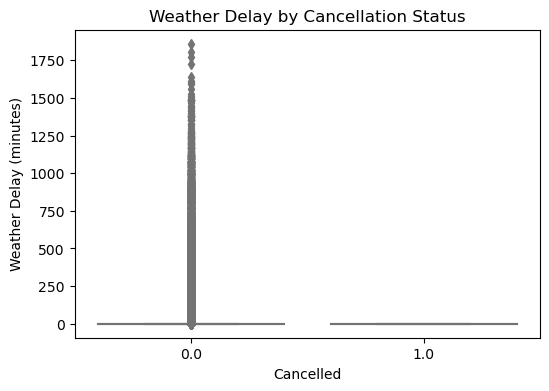

In [40]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Cancelled', y='WeatherDelay', data=df, palette='pastel')
plt.title("Weather Delay by Cancellation Status")
plt.xlabel("Cancelled")
plt.ylabel("Weather Delay (minutes)")
plt.show()

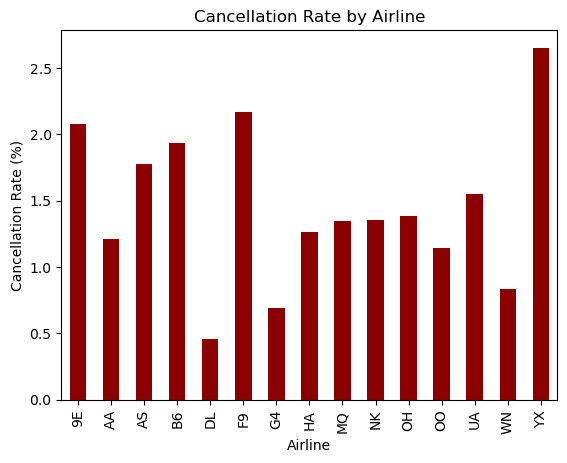

In [41]:
cancellation_rate_by_airline = df.groupby('Reporting_Airline')['Cancelled'].mean() * 100
cancellation_rate_by_airline.plot(kind='bar', color='grey', title="Cancellation Rate by Airline")
plt.xlabel("Airline")
plt.ylabel("Cancellation Rate (%)")
plt.show()

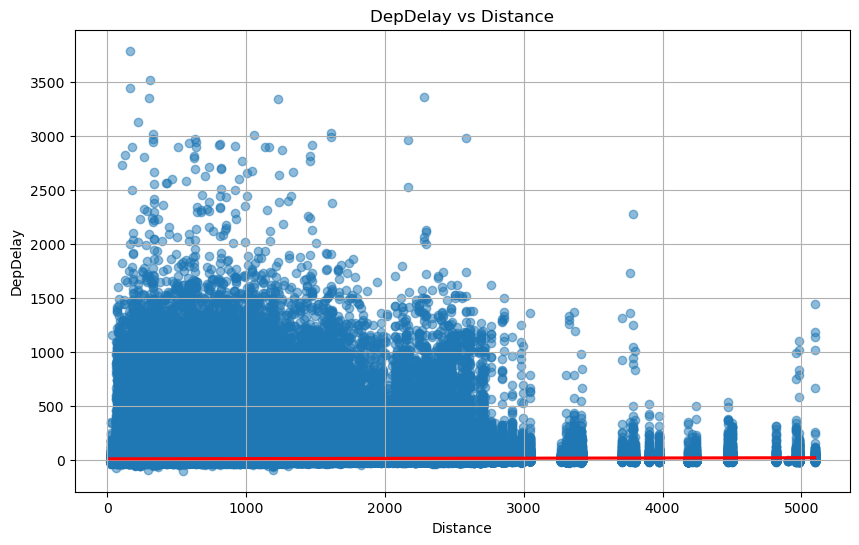

Correlation Summary:
Pearson r   = 0.02 (very weak)
Spearman ρ = 0.08 (very weak)


In [42]:
scatter_with_trend(df, 'Distance', 'DepDelay')
compute_correlations(df, 'Distance', 'DepDelay')

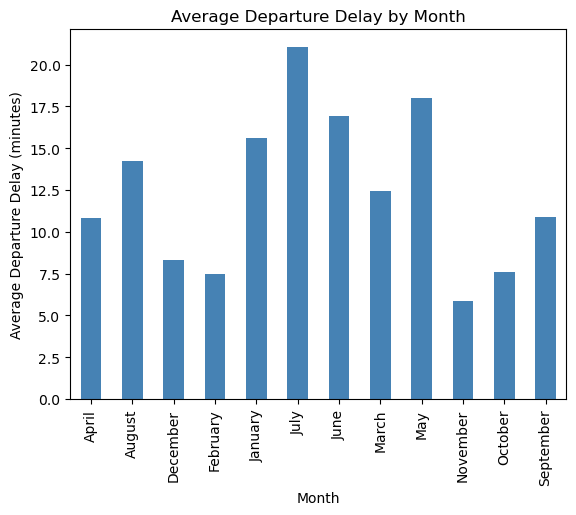

In [43]:
df['Month'] = df['FlightDate'].dt.month_name()
avg_dep_delay_by_month = df.groupby('Month')['DepDelay'].mean()
avg_dep_delay_by_month.plot(kind='bar', color='grey', title="Average Departure Delay by Month")
plt.xlabel("Month")
plt.ylabel("Average Departure Delay (minutes)")
plt.show()

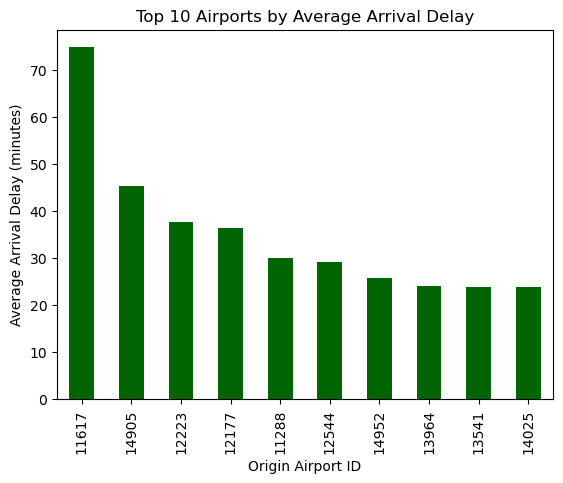

In [44]:
avg_arr_delay_by_airport = df.groupby('OriginAirportID')['ArrDelay'].mean()
avg_arr_delay_by_airport.nlargest(10).plot(kind='bar', color='grey', title="Top 10 Airports by Average Arrival Delay")
plt.xlabel("Origin Airport ID")
plt.ylabel("Average Arrival Delay (minutes)")
plt.show()


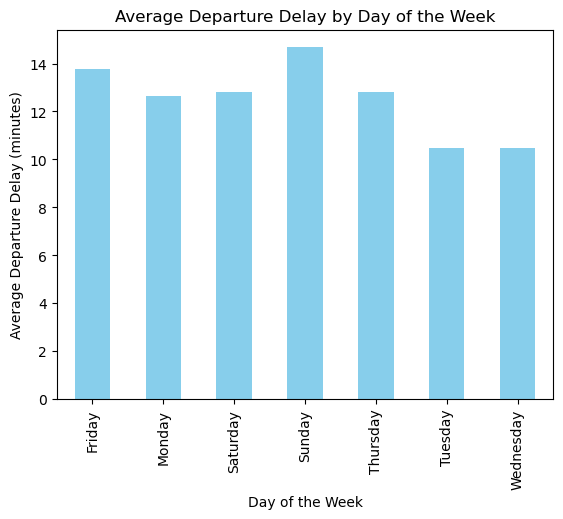

In [45]:
df['DayOfWeek'] = df['FlightDate'].dt.day_name()
avg_dep_delay_by_day = df.groupby('DayOfWeek')['DepDelay'].mean()
avg_dep_delay_by_day.plot(kind='bar', color='grey', title="Average Departure Delay by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Departure Delay (minutes)")
plt.show()


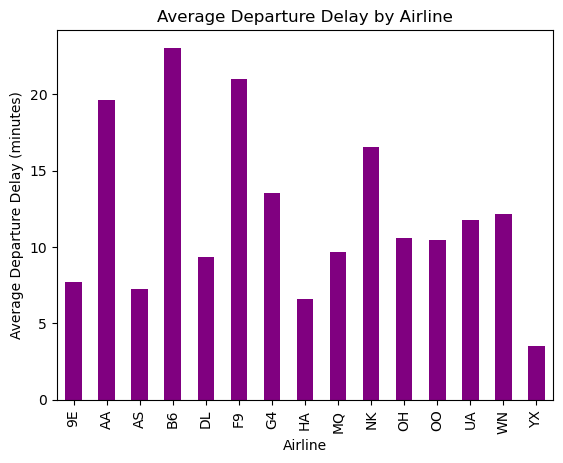

In [46]:
avg_dep_delay_by_airline = df.groupby('Reporting_Airline')['DepDelay'].mean()
avg_dep_delay_by_airline.plot(kind='bar', color='grey', title="Average Departure Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Average Departure Delay (minutes)")
plt.show()


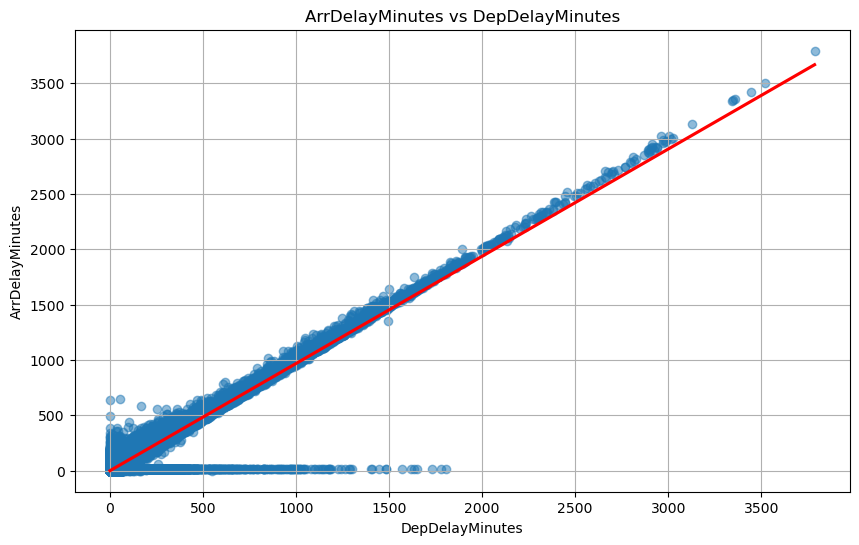

Correlation Summary:
Pearson r   = 0.98 (very strong)
Spearman ρ = 0.74 (strong)


In [54]:
scatter_with_trend(df, 'DepDelayMinutes', 'ArrDelayMinutes')
compute_correlations(df, 'DepDelayMinutes', 'ArrDelayMinutes')


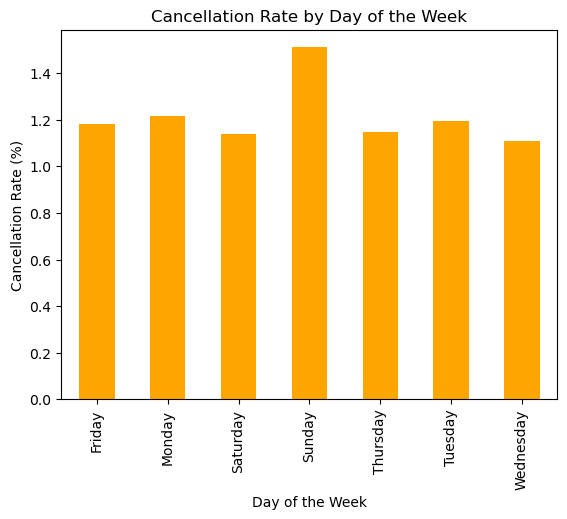

In [55]:
cancellation_rate_by_day = df.groupby('DayOfWeek')['Cancelled'].mean() * 100
cancellation_rate_by_day.plot(kind='bar', color='grey', title="Cancellation Rate by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Cancellation Rate (%)")
plt.show()
